In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
import tensorflow
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.models import Model
from tensorflow.keras.models import Model, load_model
from __future__ import print_function, division
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from glob import glob
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, SeparableConv2D, LeakyReLU, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
fid = drive.ListFile({'q':"title='binary_ct.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('binary_ct.zip')

In [9]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [10]:
!unzip binary_ct.zip

Streaming output truncated to the last 5000 lines.
  inflating: binary_ct/train/covid/pCT1000.jpg  
  inflating: binary_ct/train/covid/pCT1006.jpg  
  inflating: binary_ct/train/covid/pCT1009.jpg  
  inflating: binary_ct/train/covid/pCT1012.jpg  
  inflating: binary_ct/train/covid/pCT1013.jpg  
  inflating: binary_ct/train/covid/pCT1015.jpg  
  inflating: binary_ct/train/covid/pCT1018.jpg  
  inflating: binary_ct/train/covid/pCT1019.jpg  
  inflating: binary_ct/train/covid/pCT1022.jpg  
  inflating: binary_ct/train/covid/pCT1024.jpg  
  inflating: binary_ct/train/covid/pCT1025.jpg  
  inflating: binary_ct/train/covid/pCT1030.jpg  
  inflating: binary_ct/train/covid/pCT1044.jpg  
  inflating: binary_ct/train/covid/pCT1046.jpg  
  inflating: binary_ct/train/covid/pCT1048.jpg  
  inflating: binary_ct/train/covid/pCT1050.jpg  
  inflating: binary_ct/train/covid/pCT1051.jpg  
  inflating: binary_ct/train/covid/pCT1053.jpg  
  inflating: binary_ct/train/covid/pCT1056.jpg  
  inflating: binar

In [11]:
PATH = '/content/binary_ct'
os.listdir(PATH)
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')
train_normal_dir = os.path.join(train_dir,
                                'normal')
train_covid19_dir = os.path.join(train_dir,
                               'covid')

test_normal_dir = os.path.join(test_dir,
                               'normal')
test_covid19_dir = os.path.join(test_dir,
                              'covid')
len(os.listdir(train_normal_dir))


3000

In [12]:
IMG_HEIGHT = 212
IMG_WIDTH = 212
batch_size = 128
epochs = 100

image_gen = ImageDataGenerator(
    rescale=1./255
    )
train_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical')
test_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical')
num_normal_train = len(os.listdir(train_normal_dir))
num_covid_train = len(os.listdir(train_covid19_dir))

num_normal_test = len(os.listdir(test_normal_dir))
num_covid_test = len(os.listdir(test_covid19_dir))

total_train = num_normal_train + num_covid_train 
total_test = num_normal_test + num_covid_test

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
from keras.applications import ResNet50
resModel = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [14]:
outputs = resModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resModel.input, outputs=outputs)

for layer in resModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:

# Train the model.
history=model.fit_generator(train_data_gen,
         steps_per_epoch = total_train // batch_size,
         epochs = epochs,
         validation_data = test_data_gen
         
         )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
46/46 [==============================] - 30s 445ms/step - loss: 6.9367 - accuracy: 0.5974 - val_loss: 0.9541 - val_accuracy: 0.8400
Epoch 2/100
46/46 [==============================] - 19s 414ms/step - loss: 0.5042 - accuracy: 0.8858 - val_loss: 0.2863 - val_accuracy: 0.9350
Epoch 3/100
46/46 [==============================] - 19s 414ms/step - loss: 0.0933 - accuracy: 0.9643 - val_loss: 0.2821 - val_accuracy: 0.9440
Epoch 4/100
46/46 [==============================] - 19s 417ms/step - loss: 0.1031 - accuracy: 0.9597 - val_loss: 0.3699 - val_accuracy: 0.8900
Epoch 5/100
46/46 [==============================] - 19s 410ms/step - loss: 0.0712 - accuracy: 0.9721 - val_loss: 0.4783 - val_accuracy: 0.8640
Epoch 6/100
46/46 [==============================] - 19s 415ms/step - loss: 0.1625 - accuracy: 0.9439 - val_loss: 0.2954 - val_accuracy: 0.9430
Epoch 7/100
46/46 [==============================] - 19s 413ms/step - loss: 0.0547 - accuracy: 0.9797 - val_loss: 0.4062 - val_accuracy:

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         mode='lines+markers',
                         name='Validation accuracy'))
fig.update_layout(title='Accuracy',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

In [17]:
pred= model.predict_generator(test_data_gen, total_test // batch_size)
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_data_gen.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1
 0 1]
{'covid': 0, 'normal': 1}
['normal', 'covid', 'covid', 'normal', 'normal', 'normal', 'normal', 'covid', 'normal', 'normal', 'normal', 'normal', 'normal', 'covid', 'covid', 'normal', 'normal', 'normal', 'normal', 'normal', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'normal', 'normal', 'covid', 'normal', 'covid', 'covid', 'normal', 'normal', 'normal', 'normal', 'normal', 'covid', 'covid', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'covid', 'normal', 'normal', 'covid', 'covid', 'normal', 'normal', 'norm

In [24]:

from sklearn.metrics import confusion_matrix

y_true = np.array([0] * 112 + [1] * 112)
y_pred = predicted_class_indices

cf=confusion_matrix(y_true, y_pred)
print(cf)

[[44 68]
 [42 70]]


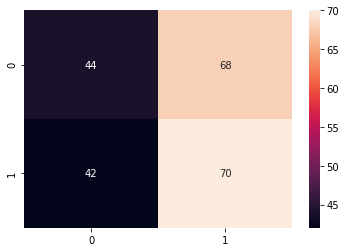

In [25]:
import seaborn as sns
sns.heatmap(cf, annot=True)

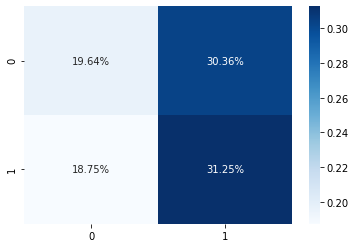

In [26]:
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

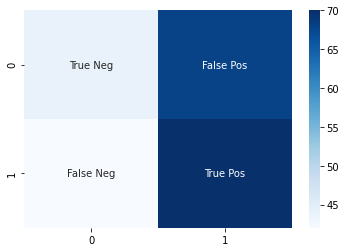

In [29]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


# Print f1, precision, and recall scores
print(precision_score(y_true, y_pred , average="macro"))
print(recall_score(y_true, y_pred , average="macro"))
print(f1_score(y_true, y_pred , average="macro"))

0.5094371418941692
0.5089285714285714
0.5022222222222222


In [31]:
from sklearn.metrics import classification_report



print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.39      0.44       112
           1       0.51      0.62      0.56       112

    accuracy                           0.51       224
   macro avg       0.51      0.51      0.50       224
weighted avg       0.51      0.51      0.50       224

